<a href="https://colab.research.google.com/github/Bolorooo24/CV-ML_labs/blob/main/Lab_2/Task_1/CNN_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
batch_size = 64

In [ ]:
import torchvision.datasets as datasets
dataset = datasets.CIFAR100(root='./cifar100', train=True, download=True, transform=transform)

In [ ]:
# put dataset structure into dictionary
classes_dict  = {}

for img, label in dataset:
  if label not in classes_dict:
    classes_dict[label] = []
  classes_dict[label].append(img)

In [ ]:
# create subset of the dataset
import random
from torch.utils.data import DataLoader, TensorDataset

def subset_create(classes_dict, num_classes, num_samples):
  sample_classes  = random.sample(list(classes_dict.keys()), num_classes)
  data = []
  label = []
  class_mapping = {cls: idx for idx, cls in enumerate(sample_classes)}

  for c in sample_classes:
    sample_images = random.sample(classes_dict[c], num_samples)
    data.extend(sample_images)
    label.extend([class_mapping[c]]*num_samples)

  return TensorDataset(torch.stack(data), torch.tensor(label))

In [ ]:
# create each subset

subsets = {
    "10x10": subset_create(classes_dict, 10, 10),
    "10x100": subset_create(classes_dict, 10, 100),
    "10x200": subset_create(classes_dict, 10, 200),
    "100x10": subset_create(classes_dict, 100, 10),
    "100x100": subset_create(classes_dict, 100, 100),
    "100x200": subset_create(classes_dict, 100, 200),
}
print("subset created!!")

In [ ]:
class Net(nn.Module):
    def __init__(self, classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



In [15]:
# train function on multiple subsets
def train(model, train_loader, optimizer, criterion, epochs):
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    for i, labels in train_loader:
      i, labels = i.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(i)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss/len(train_loader):.4f}")





In [ ]:
def test(model, test_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for i, labels in test_loader:
      i, labels = i.to(device), labels.to(device)
      outputs = model(i)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  return 100 * correct / total

In [ ]:
device = torch.device("cpu")


In [ ]:
for subset_name, subset in subsets.items():
    print(f"Subset {subset_name} labels: {set(subset.tensors[1].tolist())}")

In [16]:
results = {}
epochs = 50

for subset_name, subset in subsets.items():
  print(f"Subset {subset_name} labels: {set(subset.tensors[1].tolist())}")
  num_classes = len(set(subset.tensors[1].tolist()))
  train_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)

  model = Net(classes=num_classes).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  criterion = nn.CrossEntropyLoss()

  train(model, train_loader, optimizer, criterion, epochs)
  test_loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
  accuracy = test(model, test_loader)
  print(f"Accuracy of {subset_name}: {accuracy:.2f}%")
  torch.save(model.state_dict(), f"{subset_name}_model.pth")
  results[subset_name] = accuracy
print("\nFinal results:")
for subset_name, accuracy in results.items():
    print(f"{subset_name}: {accuracy:.2f}%")

Subset 10x10 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Epoch 1, Loss: 2.3305
Epoch 2, Loss: 2.3143
Epoch 3, Loss: 2.2737
Epoch 4, Loss: 2.2845
Epoch 5, Loss: 2.3094
Epoch 6, Loss: 2.2827
Epoch 7, Loss: 2.2899
Epoch 8, Loss: 2.2712
Epoch 9, Loss: 2.2807
Epoch 10, Loss: 2.2455
Epoch 11, Loss: 2.2240
Epoch 12, Loss: 2.2184
Epoch 13, Loss: 2.2396
Epoch 14, Loss: 2.2015
Epoch 15, Loss: 2.1992
Epoch 16, Loss: 2.1912
Epoch 17, Loss: 2.1973
Epoch 18, Loss: 2.1750
Epoch 19, Loss: 2.1660
Epoch 20, Loss: 2.1560
Epoch 21, Loss: 2.1251
Epoch 22, Loss: 2.1326
Epoch 23, Loss: 2.1299
Epoch 24, Loss: 2.1369
Epoch 25, Loss: 2.1168
Epoch 26, Loss: 2.0898
Epoch 27, Loss: 2.0729
Epoch 28, Loss: 2.0639
Epoch 29, Loss: 2.1082
Epoch 30, Loss: 2.0703
Epoch 31, Loss: 2.0392
Epoch 32, Loss: 2.0161
Epoch 33, Loss: 2.0345
Epoch 34, Loss: 1.9835
Epoch 35, Loss: 2.0344
Epoch 36, Loss: 2.0172
Epoch 37, Loss: 1.9875
Epoch 38, Loss: 2.0010
Epoch 39, Loss: 1.9917
Epoch 40, Loss: 1.9533
Epoch 41, Loss: 1.9911
Epoch 42, Loss

In [18]:
for subset_name, accuracy in results.items():
    print(f"subset {subset_name}: Accuracy = {accuracy:.2f}%")

subset 10x10: Accuracy = 79.00%
subset 10x100: Accuracy = 90.00%
subset 10x200: Accuracy = 94.50%
subset 100x10: Accuracy = 28.30%
subset 100x100: Accuracy = 57.51%
subset 100x200: Accuracy = 70.64%


Files already downloaded and verified
Model: 10x10
Predicted Class: aquarium_fish
Confidence: 0.16%


<ipython-input-22-7c1e998009c4>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{subset_name}_model.pth"))


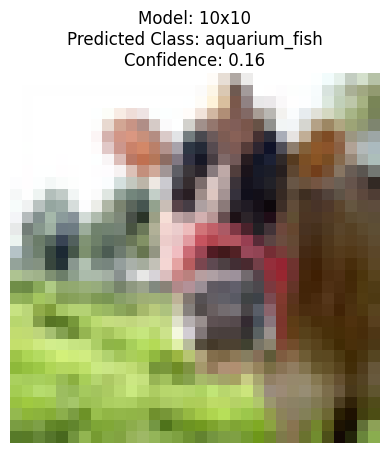

Model: 10x100
Predicted Class: apple
Confidence: 0.43%


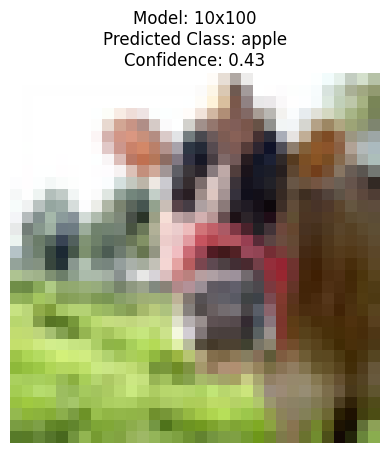

Model: 10x200
Predicted Class: bicycle
Confidence: 0.50%


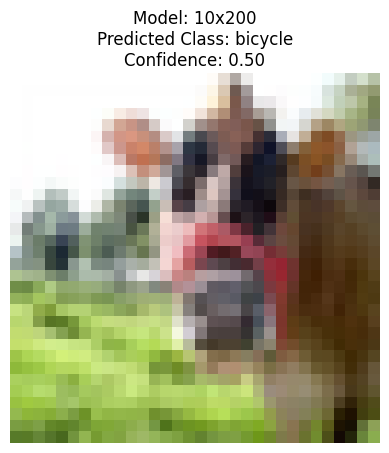

Model: 100x10
Predicted Class: raccoon
Confidence: 0.03%


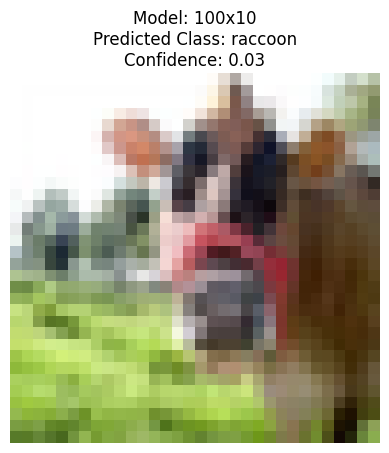

Model: 100x100
Predicted Class: bicycle
Confidence: 0.06%


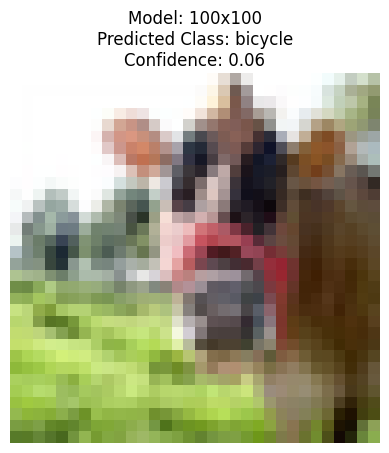

Model: 100x200
Predicted Class: shrew
Confidence: 0.11%


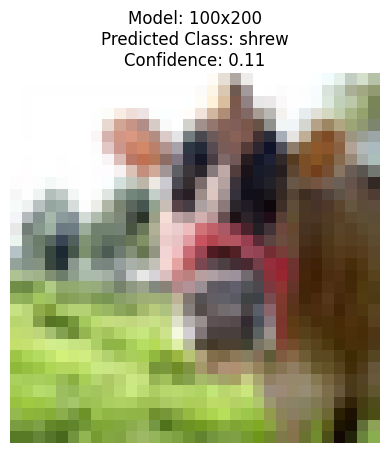

In [22]:
import numpy as np


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

subsets = {
    "10x10": 10,
    "10x100": 10,
    "10x200": 10,
    "100x10": 100,
    "100x100": 100,
    "100x200": 100,
}

dataset = datasets.CIFAR100(root='./cifar100', train=True, download=True)
image, label = dataset[0]
classes = dataset.classes
image_np = np.array(image)
image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
input_image = transform(image_np)
input_image = input_image.unsqueeze(0).to(device)

for subset_name, num_classes in subsets.items():
    model = Net(classes=num_classes).to(device)
    model.load_state_dict(torch.load(f"{subset_name}_model.pth"))
    model.eval()
    with torch.no_grad():
        outputs = model(input_image)
        _, predicted = torch.max(outputs, 1)
    predicted_class = classes[predicted.item()]
    confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()
    print(f"Model: {subset_name}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
    plt.imshow(image_np)
    plt.title(f'Model: {subset_name}\nPredicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()



Files already downloaded and verified
Model: 10x10
Predicted Class: aquarium_fish
Confidence: 0.15%


<ipython-input-23-1da5279b94b1>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{subset_name}_model.pth"))


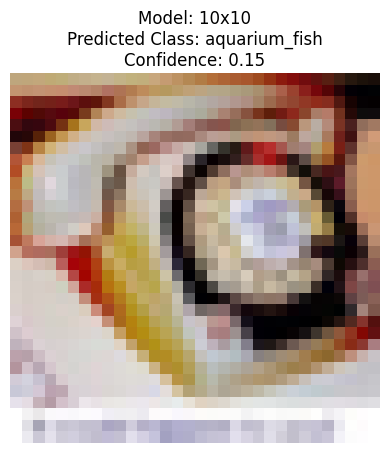

Model: 10x100
Predicted Class: aquarium_fish
Confidence: 0.39%


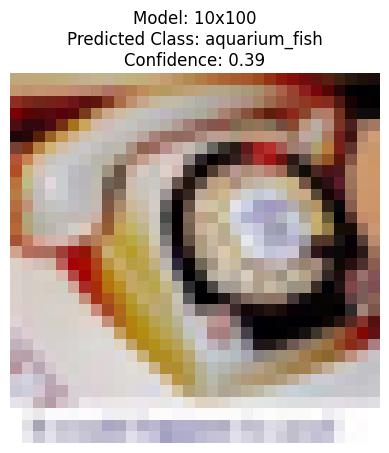

Model: 10x200
Predicted Class: bee
Confidence: 0.67%


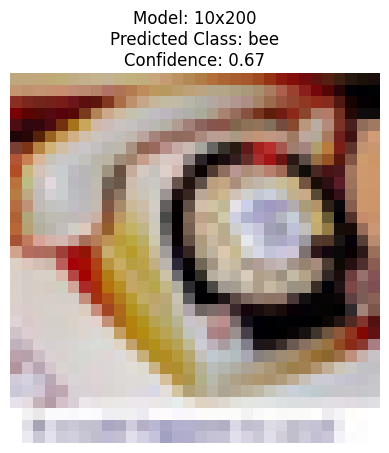

Model: 100x10
Predicted Class: worm
Confidence: 0.06%


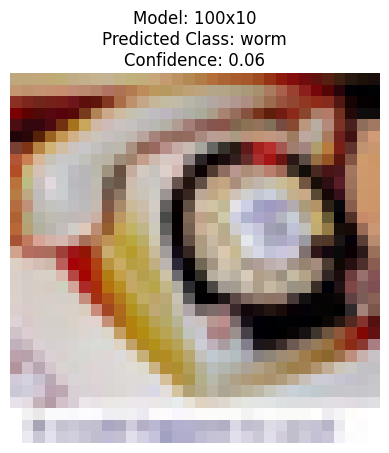

Model: 100x100
Predicted Class: ray
Confidence: 0.41%


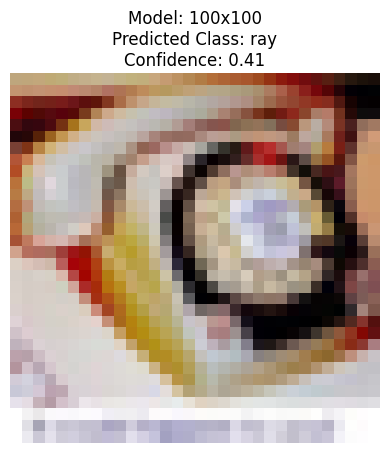

Model: 100x200
Predicted Class: elephant
Confidence: 0.32%


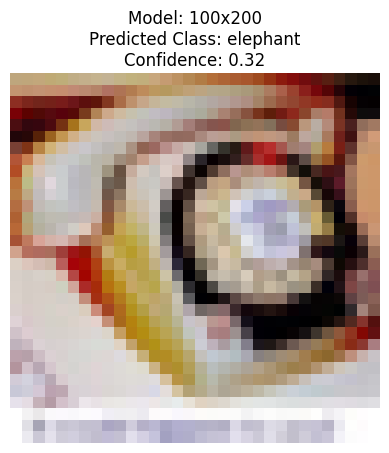

In [23]:
import numpy as np


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

subsets = {
    "10x10": 10,
    "10x100": 10,
    "10x200": 10,
    "100x10": 100,
    "100x100": 100,
    "100x200": 100,
}

dataset = datasets.CIFAR100(root='./cifar100', train=True, download=True)
image, label = dataset[5]
classes = dataset.classes
image_np = np.array(image)
image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
input_image = transform(image_np)
input_image = input_image.unsqueeze(0).to(device)

for subset_name, num_classes in subsets.items():
    model = Net(classes=num_classes).to(device)
    model.load_state_dict(torch.load(f"{subset_name}_model.pth"))
    model.eval()
    with torch.no_grad():
        outputs = model(input_image)
        _, predicted = torch.max(outputs, 1)
    predicted_class = classes[predicted.item()]
    confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()
    print(f"Model: {subset_name}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
    plt.imshow(image_np)
    plt.title(f'Model: {subset_name}\nPredicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()

